# Trader Performance and Market Sentiment Analysis

## Objective

The goal of this assignment is to understand how Bitcoin market sentiment
(Fear and Greed Index) is related to trader performance.The focus is on profit, trading activity, and differences between
small and large traders.

I analyzed historical trade data and check how traders behave during
Fear and Greed periods.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

In [3]:
## Loading Datasets
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

## Data Description

We are using two datasets:

1. Trader data from Hyperliquid which contains individual trade records
   such as account, trade size, trade side, and profit or loss.

2. Bitcoin Fear and Greed Index data which shows daily market sentiment
   classified as Fear or Greed.


In [4]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [5]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [6]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [7]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [8]:
trades.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [9]:
sentiment.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

## Date Alignment

Trade data is recorded with timestamps, while sentiment data is available
on a daily basis.

To combine both datasets, trade timestamps are converted to dates so that
each trade can be matched with the sentiment of that day.


In [10]:
trades['Date'] = pd.to_datetime(trades['Timestamp'], unit='ms').dt.date
#The trade data contains timestamps in milliseconds.To convert them into readable dates, the unit is specified as milliseconds.
sentiment['Date'] = pd.to_datetime(sentiment['date']).dt.date

In [11]:
trades[['Timestamp', 'Date']].head()

,Timestamp,Date
0,1.730000e+12,2024-10-27
1,1.730000e+12,2024-10-27
2,1.730000e+12,2024-10-27
3,1.730000e+12,2024-10-27
4,1.730000e+12,2024-10-27


### Merging(Left Join) Two Datasets

In [12]:
merged = pd.merge(
    trades,
    sentiment[['Date', 'classification', 'value']],
    on='Date',
    how='left'
)

### Handle missing values

In [13]:
merged['classification'] = merged['classification'].fillna('Unknown')
merged['value'] = merged['value'].ffill()

In [26]:
sentiment.isnull().sum()

timestamp         0
value             0
classification    0
date              0
Date              0
dtype: int64

## Feature Engineering

Trade data is grouped by trader and date to understand daily performance.

The following metrics are calculated:
- Win rate to measure how often trades are profitable
- Total profit or loss for the day
- Total trading volume
- Percentage of sell trades

These metrics help compare trader behavior during different market sentiment periods.


In [15]:
merged['is_win'] = merged['Closed PnL'] > 0  # indicates whether a trade was profitable
merged['is_sell'] = merged['Side'] == 'SELL' # indicates whether a trade was sale

## Trader Performance Calculation

Trade data is aggregated at a daily level for each trader.
This helps us analyze performance patterns instead of individual trades.


In [16]:
# Example
win_rate = merged['is_win'].mean()
win_rate

np.float64(0.4112648183918494)

In [17]:
daily_metrics = (
    merged
    .groupby(['Account', 'Date', 'classification'])
    .agg(
        trades=('Closed PnL', 'count'),
        win_rate=('is_win', 'mean'),
        total_pnl=('Closed PnL', 'sum'),
        total_volume=('Size USD', 'sum'),
        sell_ratio=('is_sell', 'mean')
    )
    .reset_index()
)

In [18]:
daily_metrics

,Account,Date,classification,trades,win_rate,total_pnl,total_volume,sell_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,462,0.025974,-3.275059e+05,6842632.02,0.699134
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,3356,0.405542,1.927736e+06,54854631.95,0.531585
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,320,0.531250,2.060745e+04,797679.97,0.546875
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,3533,0.435041,1.709873e+04,5982611.50,0.567506
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,Unknown,3427,0.442369,1.017915e+04,5255196.19,0.596732
...,...,...,...,...,...,...,...,...
97,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-02-19,Fear,2211,0.372230,3.254420e+05,17917884.11,0.523293
98,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,2025-06-15,Unknown,163,0.006135,-1.165946e+05,2091724.18,0.447853
99,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2024-10-27,Greed,9883,0.569260,6.842150e+05,26617723.76,0.687140
100,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-02-19,Fear,26651,0.384864,1.269680e+05,41437969.80,0.528423


## Trader Categories

Traders are grouped into Retail, Mid, and Whale categories based on
their total trading volume.

This helps in comparing how different types of traders behave under
different market sentiment conditions.


In [19]:
account_volume = daily_metrics.groupby('Account')['total_volume'].sum()

q50 = account_volume.quantile(0.5)
q90 = account_volume.quantile(0.9)

def trader_tier(v):
    if v >= q90:
        return 'Whale'
    elif v >= q50:
        return 'Mid'
    else:
        return 'Retail'

daily_metrics['tier'] = daily_metrics['Account'].map(
    lambda x: trader_tier(account_volume[x])
)


In [20]:
daily_metrics['tier'].value_counts()

tier
Retail    50
Mid       40
Whale     12
Name: count, dtype: int64

## Exploratory Data Analysis

Basic visual analysis is done to compare trader performance during
different sentiment categories such as Fear and Greed.


### Trades by sentiment

In [21]:
merged['classification'].value_counts()

classification
Fear             133871
Greed             36289
Unknown           26961
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64

### profitability vs sentiment
The chart below shows how trader profit and loss varies across
different sentiment categories.


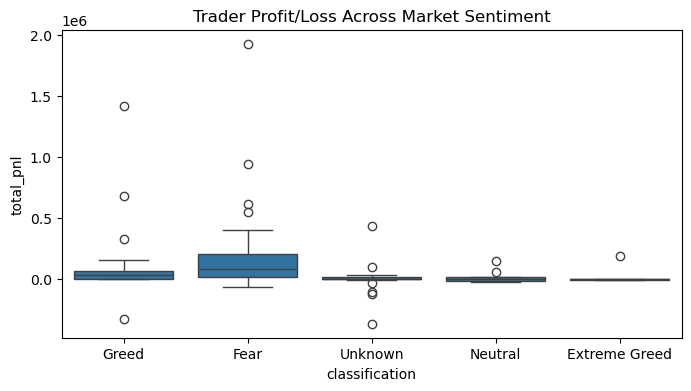

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(data=daily_metrics, x='classification', y='total_pnl')
plt.title("Trader Profit/Loss Across Market Sentiment")
plt.show()

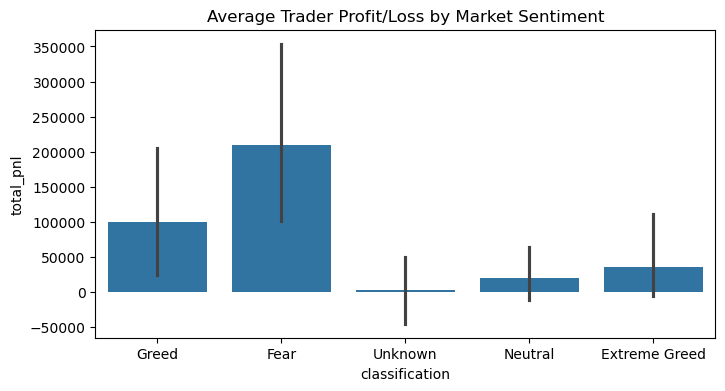

In [23]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=daily_metrics,
    x='classification',
    y='total_pnl'
)
plt.title("Average Trader Profit/Loss by Market Sentiment")
plt.show()

# Performance Comparison

A simple statistical test is used to compare trader performance
between Fear and Greed periods to check if there is a meaningful difference.

In [24]:
fear_pnl = daily_metrics[
    daily_metrics['classification'].str.contains('Fear', na=False)
]['total_pnl']

greed_pnl = daily_metrics[
    daily_metrics['classification'].str.contains('Greed', na=False)
]['total_pnl']

In [25]:
from scipy.stats import ttest_ind
ttest_ind(greed_pnl, fear_pnl, nan_policy='omit')

TtestResult(statistic=np.float64(-1.5159970268606153), pvalue=np.float64(0.1342241983001715), df=np.float64(67.0))

## Key Insights

- Trader performance is generally weaker during Fear and Extreme Fear periods.
  Many traders show higher losses during these times.

- Selling activity is higher during Fear periods, which suggests that
  traders may be exiting positions due to panic or uncertainty.

- During Greed periods, overall trader performance improves compared
  to Fear periods.

- High-volume traders (Whales) tend to have more stable performance
  compared to Retail traders, especially during volatile sentiment phases.

- Some traders are able to remain profitable across both Fear and Greed
  periods, indicating more consistent trading behavior.


## Conclusion

This analysis shows that market sentiment has a clear relationship
with trader performance and behavior.

Traders tend to perform worse during Fear periods, where selling activity
is higher and losses are more common. Performance improves during Greed
periods, especially for larger traders.

Overall, market sentiment can be useful for understanding trader behavior.
Being aware of Fear and Greed conditions may help traders avoid emotional
decisions and manage risk more effectively.
